In [10]:
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, to_date, sum as sum_
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, lag, lead, count
from pyspark.sql.functions import mean

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [22]:
# Load the dataset
pt_data = spark.read.csv("dataset/Precipitation_Avg-temperature.csv", header=True)

In [23]:
pt_data.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- PRCP: string (nullable = true)
 |-- TAVG: string (nullable = true)
 |-- TMAX: string (nullable = true)
 |-- TMIN: string (nullable = true)



In [24]:
pt_data.show()

+-----------+--------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|          NAME|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+--------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-02|0.00|  78|NULL|  72|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-03|0.00|  81|  87|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-04|0.00|  83|  88|  69|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-05|0.00|  84|  90|  65|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-06|0.00|  82|  88|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-07|0.00|  80|  89|  68|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-08|0.00|  82|  90|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-09|0.00|  83|  89|  71|
|CEM00043441|KURUNEGA

In [25]:
# Convert the columns to integer type
pt_data = pt_data.withColumn("PRCP", col("PRCP").cast("integer")) \
       .withColumn("TAVG", col("TAVG").cast("integer")) \
       .withColumn("TMAX", col("TMAX").cast("integer")) \
       .withColumn("TMIN", col("TMIN").cast("integer"))
pt_data = pt_data.withColumn("DATE", to_date(col("DATE"), 'yyyy-MM-dd'))

# Show the updated DataFrame schema to confirm the changes
pt_data.printSchema()
pt_data.show(5)

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- DATE: date (nullable = true)
 |-- PRCP: integer (nullable = true)
 |-- TAVG: integer (nullable = true)
 |-- TMAX: integer (nullable = true)
 |-- TMIN: integer (nullable = true)

+-----------+--------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|          NAME|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+--------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-02|   0|  78|NULL|  72|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-03|   0|  81|  87|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-04|   0|  83|  88|  69|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-05|   0|  84|  9

In [26]:
unique_locations_count = pt_data.select("NAME").distinct().count()
print(f"Number of unique values in the 'NAME' column: {unique_locations_count}")
pt_data.select("NAME").distinct().show()

Number of unique values in the 'NAME' column: 5
+----------------+
|            NAME|
+----------------+
|  KURUNEGALA, CE|
|    PUTTALAM, CE|
|     COLOMBO, CE|
|NUWARA ELIYA, CE|
|   CHINA BAY, CE|
+----------------+



### DATA PREPROCESSING

In [27]:
# Checking the sum of the Null values
pt_data.select(*[sum_(col(c).isNull().cast("int")).alias(c) for c in pt_data.columns]).show()

+-------+----+--------+---------+---------+----+----+----+----+----+
|STATION|NAME|LATITUDE|LONGITUDE|ELEVATION|DATE|PRCP|TAVG|TMAX|TMIN|
+-------+----+--------+---------+---------+----+----+----+----+----+
|      0|   0|       0|        0|        0|   0|  37|   0| 959|1646|
+-------+----+--------+---------+---------+----+----+----+----+----+



In [28]:
# Initialize a counter for null values
null_count = pt_data.filter(col("PRCP").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("DATE")
    forward_windowSpec = Window.orderBy("DATE")
    
    # Use lag to carry the last observation forward
    previous_value = lag("PRCP", 1).over(backward_windowSpec)
    pt_data = pt_data.withColumn("PRCP", coalesce("PRCP", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("PRCP", 1).over(forward_windowSpec)
    pt_data = pt_data.withColumn("PRCP", coalesce("PRCP", next_value))
    
    # Update the null count
    null_count = pt_data.filter(col("PRCP").isNull()).count()

In [29]:
# Initialize a counter for null values
null_count = pt_data.filter(col("TMAX").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("DATE")
    forward_windowSpec = Window.orderBy("DATE")
    
    # Use lag to carry the last observation forward
    previous_value = lag("TMAX", 1).over(backward_windowSpec)
    pt_data = pt_data.withColumn("TMAX", coalesce("TMAX", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("TMAX", 1).over(forward_windowSpec)
    pt_data = pt_data.withColumn("TMAX", coalesce("TMAX", next_value))
    
    # Update the null count
    null_count = pt_data.filter(col("TMAX").isNull()).count()

In [31]:
# Initialize a counter for null values
null_count = pt_data.filter(col("TMIN").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("DATE")
    forward_windowSpec = Window.orderBy("DATE")
    
    # Use lag to carry the last observation forward
    previous_value = lag("TMIN", 1).over(backward_windowSpec)
    pt_data = pt_data.withColumn("TMIN", coalesce("TMIN", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("TMIN", 1).over(forward_windowSpec)
    pt_data = pt_data.withColumn("TMIN", coalesce("TMIN", next_value))
    
    # Update the null count
    null_count = pt_data.filter(col("TMIN").isNull()).count()

In [32]:
# Checking the sum of the Null values
pt_data.select(*[sum_(col(c).isNull().cast("int")).alias(c) for c in pt_data.columns]).show()

+-------+----+--------+---------+---------+----+----+----+----+----+
|STATION|NAME|LATITUDE|LONGITUDE|ELEVATION|DATE|PRCP|TAVG|TMAX|TMIN|
+-------+----+--------+---------+---------+----+----+----+----+----+
|      0|   0|       0|        0|        0|   0|   0|   0|   0|   0|
+-------+----+--------+---------+---------+----+----+----+----+----+



In [33]:
dataset_length = pt_data.count()
print("The length of the dataset is:", dataset_length)

The length of the dataset is: 8745


In [35]:
pt_data = pt_data.dropDuplicates()
dataset_length = pt_data.count()
print("The length of the dataset after dropping dupplicates is:", dataset_length)

The length of the dataset after dropping dupplicates is: 8745


In [36]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pt_data = pt_data.toPandas()
pt_data

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN
0,CEM00043418,"CHINA BAY, CE",8.539,81.182,1.8,2019-01-01,0,79,82,76
1,CEM00043466,"COLOMBO, CE",6.9,79.867,7.0,2019-01-01,0,81,89,74
2,CE000434730,"NUWARA ELIYA, CE",6.967,80.767,1880.0,2019-01-01,0,61,71,49
3,CEM00043424,"PUTTALAM, CE",8.033,79.833,2.0,2019-01-01,0,78,87,49
4,CEM00043441,"KURUNEGALA, CE",7.467,80.367,116.0,2019-01-02,0,78,87,72
...,...,...,...,...,...,...,...,...,...,...
8740,CEM00043441,"KURUNEGALA, CE",7.467,80.367,116.0,2023-12-31,0,79,87,75
8741,CEM00043418,"CHINA BAY, CE",8.539,81.182,1.8,2023-12-31,0,82,85,76
8742,CEM00043466,"COLOMBO, CE",6.9,79.867,7.0,2023-12-31,0,81,85,75
8743,CE000434730,"NUWARA ELIYA, CE",6.967,80.767,1880.0,2023-12-31,0,60,90,57


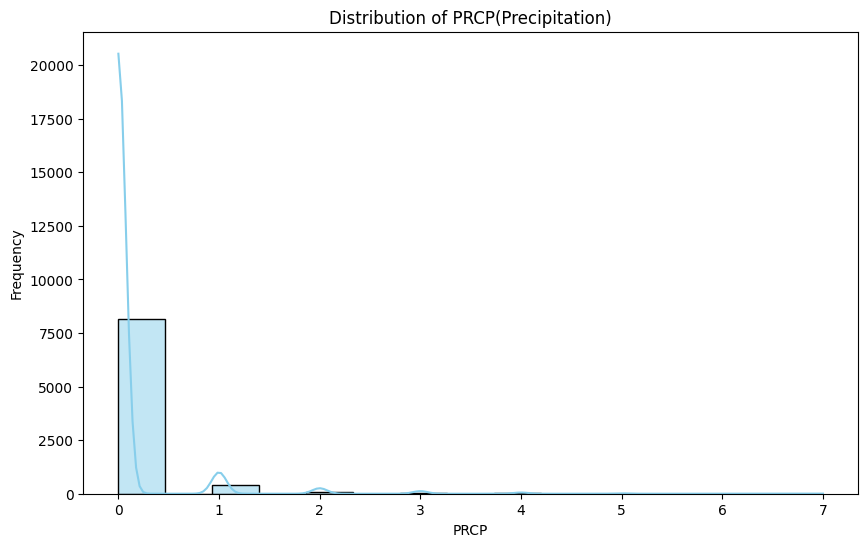

In [39]:
# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(pt_data["PRCP"], kde=True, color='skyblue')
plt.title('Distribution of PRCP(Precipitation)')
plt.xlabel('PRCP')
plt.ylabel('Frequency')
plt.show()

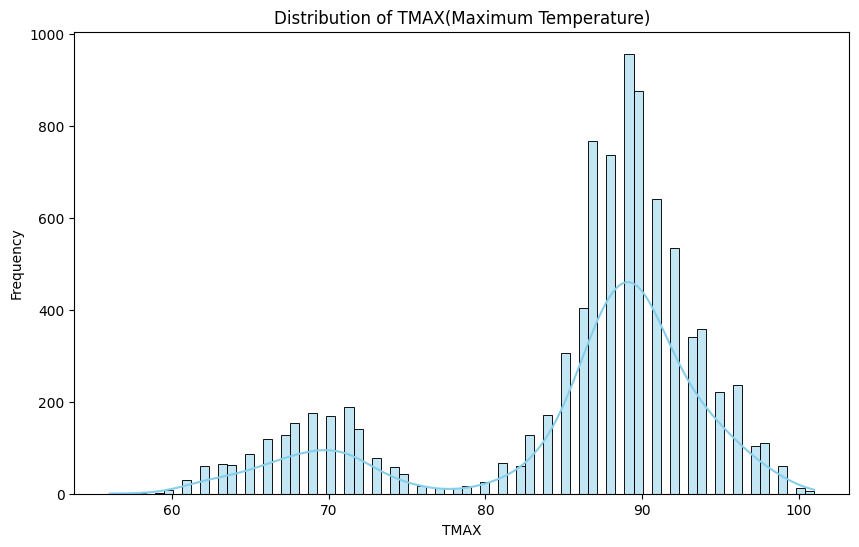

In [40]:
# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(pt_data["TMAX"], kde=True, color='skyblue')
plt.title('Distribution of TMAX(Maximum Temperature)')
plt.xlabel('TMAX')
plt.ylabel('Frequency')
plt.show()

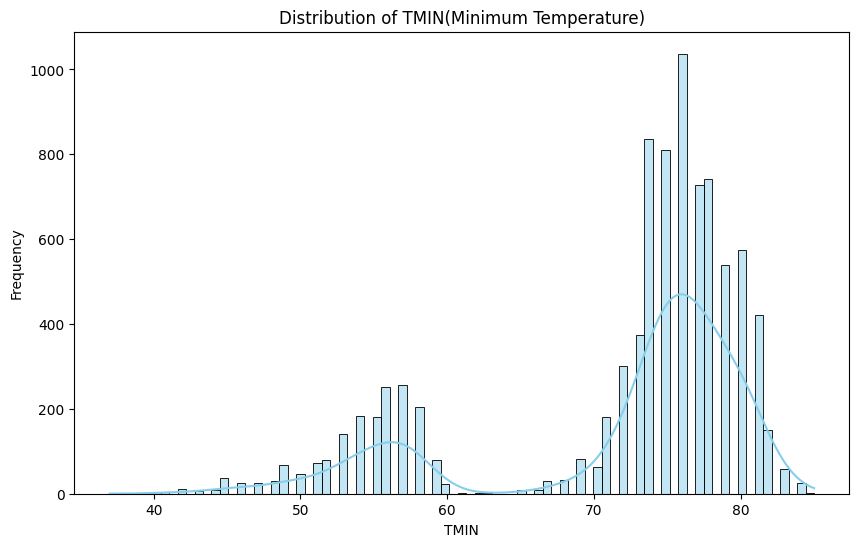

In [41]:
# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(pt_data["TMIN"], kde=True, color='skyblue')
plt.title('Distribution of TMIN(Minimum Temperature)')
plt.xlabel('TMIN')
plt.ylabel('Frequency')
plt.show()

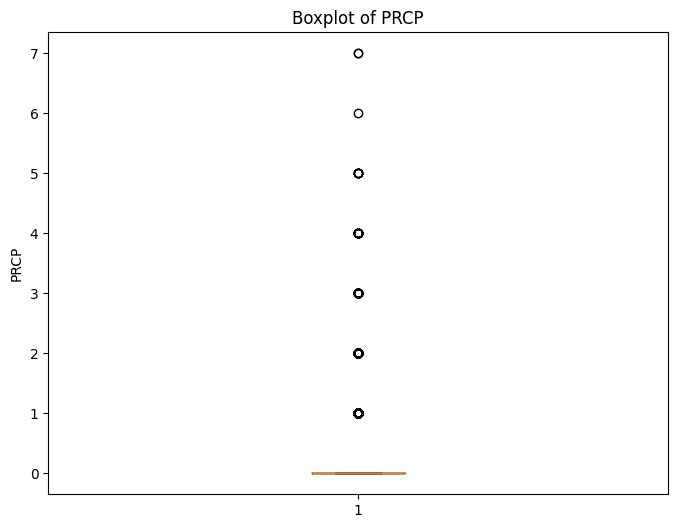

In [42]:
plt.figure(figsize=(8, 6))
plt.boxplot(pt_data['PRCP'])

# Add title and labels
plt.title('Boxplot of PRCP')
plt.ylabel('PRCP')

# Show the plot
plt.show()

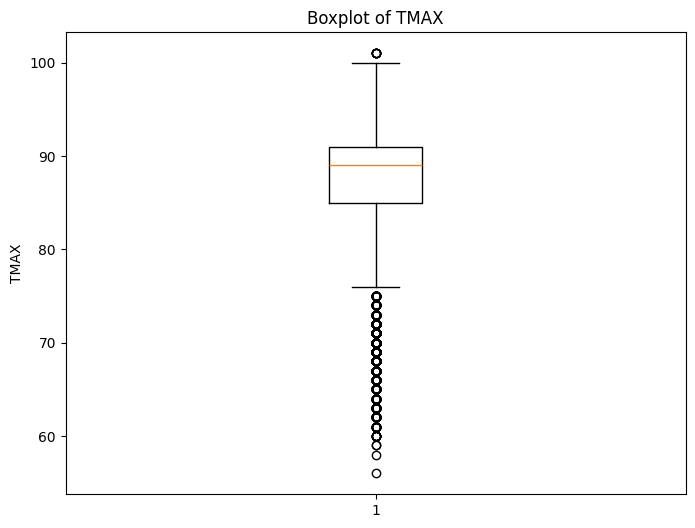

In [43]:
plt.figure(figsize=(8, 6))
plt.boxplot(pt_data['TMAX'])

# Add title and labels
plt.title('Boxplot of TMAX')
plt.ylabel('TMAX')

# Show the plot
plt.show()

In [45]:
# Upper & Lower Bound of the Dataset

# Calculate Q1, Q3, and IQR
Q1 = pt_data['TMAX'].quantile(0.25)
Q3 = pt_data['TMAX'].quantile(0.75)
IQR = Q3 - Q1

# Compute upper whisker value
upper_whisker = Q3 + 1.5 * IQR
lower_whisker = Q3 - 1.5 * IQR

# Find the highest data point within the upper whisker range
upper_bound_data = pt_data['TMAX'][pt_data['TMAX'] <= upper_whisker].max()
lower_bound_data = pt_data['TMAX'][pt_data['TMAX'] <= lower_whisker].max()

print("Upper bound within the boxplot:", upper_bound_data)
print("Lower bound within the boxplot:", lower_bound_data)

# Number of records upper the bound of the dataset
HCHO_Reading_outliers_max = pt_data[pt_data['TMAX'] >= 100].value_counts().sum()
HCHO_Reading_outliers_min = pt_data[pt_data['TMAX'] <= 82].value_counts().sum()
print(f'Number of outliers above:- {HCHO_Reading_outliers_max}')
print(f'Number of outliers below:- {HCHO_Reading_outliers_min}')

Upper bound within the boxplot: 100
Lower bound within the boxplot: 82
Number of outliers above:- 18
Number of outliers below:- 1773


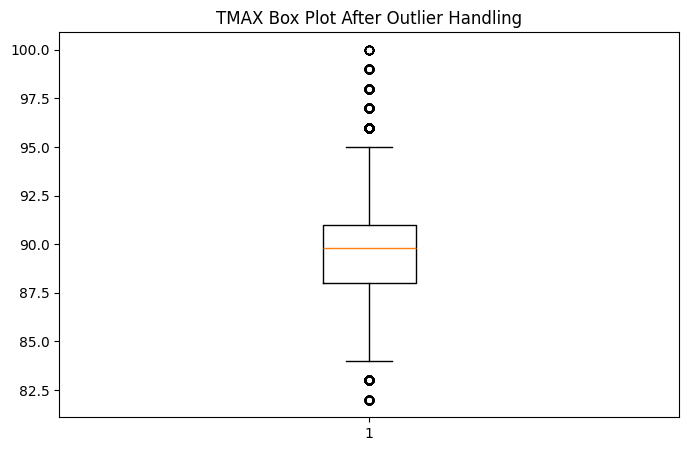

In [51]:
# Handle outliers by replacing values above 100 with the mean of values below 100
mean_tmax = pt_data.loc[pt_data["TMAX"] < 100, "TMAX"].mean()
pt_data.loc[pt_data["TMAX"] > 100, "TMAX"] = mean_tmax

# Create a box plot for the "TMAX" column after handling outliers
plt.figure(figsize=(8, 5))
plt.boxplot(x=pt_data["TMAX"])
plt.title("TMAX Box Plot After Outlier Handling")
plt.show()

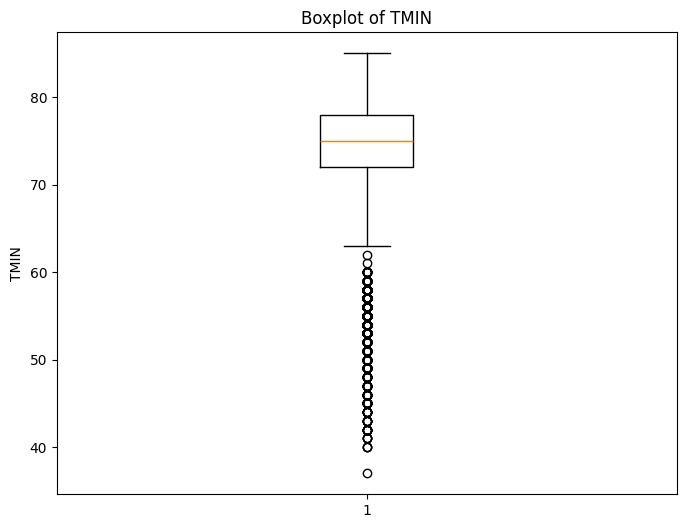

In [52]:
plt.figure(figsize=(8, 6))
plt.boxplot(pt_data['TMIN'])

# Add title and labels
plt.title('Boxplot of TMIN')
plt.ylabel('TMIN')

# Show the plot
plt.show()

In [54]:
# Upper & Lower Bound of the Dataset

# Calculate Q1, Q3, and IQR
Q1 = pt_data['TMIN'].quantile(0.25)
Q3 = pt_data['TMIN'].quantile(0.75)
IQR = Q3 - Q1

# Compute upper whisker value
upper_whisker = Q3 + 1.5 * IQR
lower_whisker = Q3 - 1.5 * IQR

# Find the highest data point within the upper whisker range
upper_bound_data = pt_data['TMIN'][pt_data['TMIN'] <= upper_whisker].max()
lower_bound_data = pt_data['TMIN'][pt_data['TMIN'] <= lower_whisker].max()

print("Upper bound within the boxplot:", upper_bound_data)
print("Lower bound within the boxplot:", lower_bound_data)

# Number of records upper the bound of the dataset
HCHO_Reading_outliers_max = pt_data[pt_data['TMIN'] >= 85].value_counts().sum()
HCHO_Reading_outliers_min = pt_data[pt_data['TMIN'] <= 69].value_counts().sum()
print(f'Number of outliers above:- {HCHO_Reading_outliers_max}')
print(f'Number of outliers below:- {HCHO_Reading_outliers_min}')

Upper bound within the boxplot: 85
Lower bound within the boxplot: 69
Number of outliers above:- 2
Number of outliers below:- 1901
